In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import scipy
import scipy.fftpack as sf
import scipy.signal as ss

%matplotlib inline
import matplotlib.pyplot as plt

In [204]:
realden = np.load('../Box/ml_data/tensorflow_tests/realden.npz',allow_pickle=True)
imagden = np.load('../Box/ml_data/tensorflow_tests/imagden.npz',allow_pickle=True)

In [205]:
x_inp = np.hstack([ realden['x_inp'][:,[0,1,3]], imagden['x_inp'][:,[1]] ])
x_inp_test = np.hstack([ realden['x_inp_test'][:,[0,1,3]], imagden['x_inp_test'][:,[1]] ])
y_tru = x_inp[1:,:]
y_tru_test = x_inp_test[1:,:]
x_inp = x_inp[:-1,:]
x_inp_test = x_inp_test[:-1,:]

#y_tru = np.hstack([ realden['y_tru'][:,[0,1,3]], imagden['y_tru'][:,[1]] ])
#y_tru_test = np.hstack([ realden['y_tru_test'][:,[0,1,3]], imagden['y_tru_test'][:,[1]] ])
print(x_inp.shape)
print(x_inp_test.shape)
print(y_tru.shape)
print(y_tru_test.shape)

(9999, 4)
(9998, 4)
(9999, 4)
(9998, 4)


In [224]:
# check symmetry of real part
print(np.sum(np.abs(realden['x_inp'][:,1] - realden['x_inp'][:,2])))

# check diagonal entries of imaginary part
print(np.sum(np.abs(imagden['x_inp'][:,0])))
print(np.sum(np.abs(imagden['x_inp'][:,3])))

# check symmetry of imaginary part
print(np.sum(np.abs(imagden['x_inp'][:,1] - imagden['x_inp'][:,2])))

# check the trace PS property
sao = np.array([[0.100000e1,0.538415],[0.538415,0.100000e1]])

psi = realden['x_inp'][:,:] + 1j*imagden['x_inp'][:,:]
psi = np.reshape(psi, (-1,2,2))
psisao = np.einsum('ijk,kl -> ijl', psi, sao)
tracepsisao = np.einsum('ijj -> i', psisao)
print(np.max(np.real(tracepsisao)))
print(np.min(np.real(tracepsisao)))

np.trace(psisao[8436,:,:])

u = np.real(psi)
u22test = (1 - u[:,0,1]*(sao[1,0]+sao[0,1]) - u[:,0,0]*sao[0,0])/sao[1,1]
np.mean(np.square( u22test - u[:,1,1] ))


0.0
0.0
0.0
0.0
1.0000095204
0.9999900345


2.8537238186783908e-12

In [4]:
# add time
timevar = np.expand_dims(np.arange(x_inp.shape[0])*2e-3,1)
x_inp = np.hstack([timevar, x_inp])
print(x_inp.shape)

(9999, 5)


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
# X is of shape n_inputs x 1
# self.freq should be of shape 1 x n_modes
# self.U is of shape n_modes x 1


class fftcellms(nn.Module):
    def __init__(self, nvec, n_modes, dx, fftinit1, fftinit2):
        super(fftcellms, self).__init__()

        self.dx = dx
        self.n_modes = n_modes

        # frequency vector (trainable)
        # nvec = 2.0*np.pi*torch.arange(n_modes, dtype=torch.float64)/n_modes
        self.freq = nn.Parameter(torch.unsqueeze(nvec, 0))
        
        # trainable weight initialized to real and imaginary parts of FFT
        self.U1 = nn.Parameter(torch.unsqueeze(fftinit1, 1))
        self.U2 = nn.Parameter(torch.unsqueeze(fftinit2, 1))
        
    def forward(self, X):
        tc = torch.cos(torch.mm(X/self.dx, self.freq))
        ts = torch.sin(torch.mm(X/self.dx, self.freq))
        part11 = torch.mm(tc,self.U1)/self.n_modes
        part12 = torch.mm(ts,self.U2)/self.n_modes
        self.out = part11 - part12
        return self.out


(9999, 4)


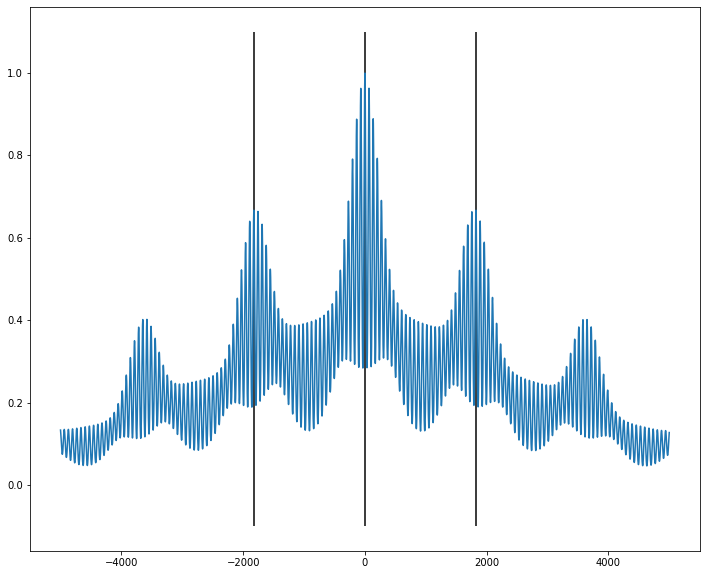

[-1825     0  1824]
[18328.77606077 22499.00798649 18358.7992183 ]
[   0 1824]


In [7]:
offset = 0
test = ss.correlate(x_inp[offset:,1:], x_inp[offset:,1:], mode='same')
print(test.shape)
plt.figure(figsize=(12,10))
realtest = np.sum(np.abs(test)**2, axis=1)
realtest = realtest/np.max(realtest)
testn = len(test)
plt.plot(np.arange(-testn//2, testn//2), realtest)
test2 = ss.find_peaks(realtest, prominence=0.4, distance=225)[0]
plt.vlines(-testn//2 + test2, ymin=-0.1, ymax=1.1)
plt.show()
print(-testn//2 + test2)
print(np.sum(np.abs(test), axis=1)[test2])
test2 = -testn//2 + test2
test3 = test2[test2>=0]
print(test3)

In [147]:
# which element to predict?
# 0, 1, 2 are real components
# 3: imaginary component
predelement = 3

# numper is how many periods of training data to use
numper = 1

# period of signal --> found this out by eyeballing/playing with data
startind = offset + test3[0]
bigt = numper*test3[1] - test3[0]
print(startind, bigt)

# capture numper periods of true target signal
truesig = y_tru[startind:(startind+bigt),predelement] # - x_inp[startind:(startind+bigt),predelement+1]

# compute FFT of the training signal
yhat = scipy.fft(truesig)

# yhat[np.abs(yhat) < 1e-1] = 0

print(np.sum(yhat==0))

0 1824
0


C:\Users\haris\Miniconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.


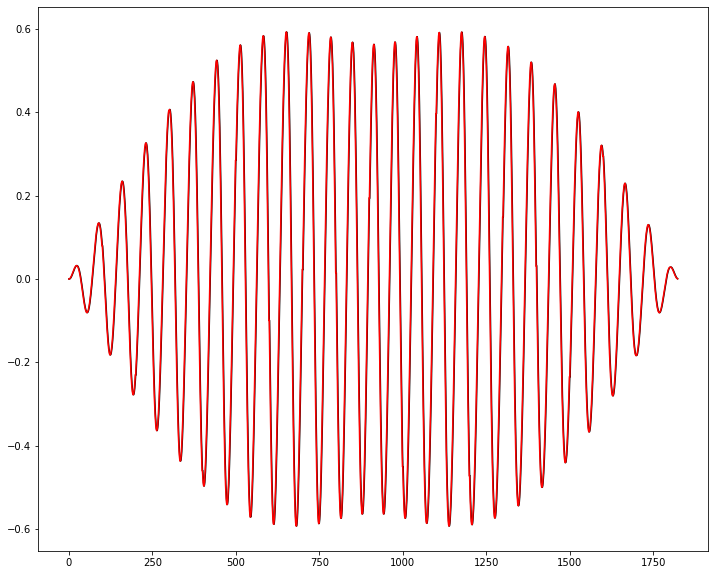

In [148]:
plt.figure(figsize=(12,10))
plt.plot(x_inp[startind:(startind+bigt),predelement+1],color='black')
plt.plot(y_tru[startind:(startind+bigt),predelement],color='red')
plt.show()


In [149]:
# low pass filter stuff
# yhattemp = sf.fftshift(yhat)
# bign = len(yhattemp)
# thresh = bign//2
# print(bign//2 - thresh, bign//2 + thresh)
# yhattemp[:(bign//2 - thresh)] = 0.
# yhattemp[(bign//2 + thresh):] = 0.
# yhat = sf.ifftshift(yhattemp)


In [150]:
# debugging stuff
# yrecon = scipy.ifft(yhat)
# print(np.sum(np.abs(yrecon - truesig)))
# fftmat = np.exp(np.matmul(np.expand_dims(np.arange(10000), 1), np.expand_dims(2j*np.pi*np.arange(10000)/10000,0)))
# print(np.linalg.norm(x_inp[:,[predelement]].T - np.matmul(fftmat, yhat)/10000))

In [151]:
nvec = 2.0*np.pi*torch.arange(bigt, dtype=torch.float64)/bigt
nvecind = np.arange(bigt, dtype=np.int64)


In [166]:
# threshold yhat
# goodind = nvecind #[:500]
goodind = np.where(np.abs(yhat) > 5e-2*np.max(np.abs(yhat)))[0]
print(len(goodind))
print(len(goodind)/bigt)

18
0.009868421052631578


In [167]:
# "fit" the fft cell on the training data
init1 = torch.tensor(np.real(yhat[goodind]),dtype=torch.float64)
init2 = torch.tensor(np.imag(yhat[goodind]),dtype=torch.float64)
model = fftcellms(nvec=nvec[goodind], n_modes=bigt, dx=2e-3, fftinit1=init1, fftinit2=init2)

In [168]:
# compute training set predictions
ypred = model(torch.tensor(timevar[:bigt], dtype=torch.float64))
print(timevar[bigt-1])

[3.646]


In [169]:
# print training error
print(np.mean(np.square(ypred.detach().numpy()[:,0] - truesig)))

0.0007991874468173372


In [170]:
print(model(torch.tensor(timevar[[100]], dtype=torch.float64)))
print(truesig[100])

tensor([[0.0853]], dtype=torch.float64, grad_fn=<SubBackward0>)
0.0798611


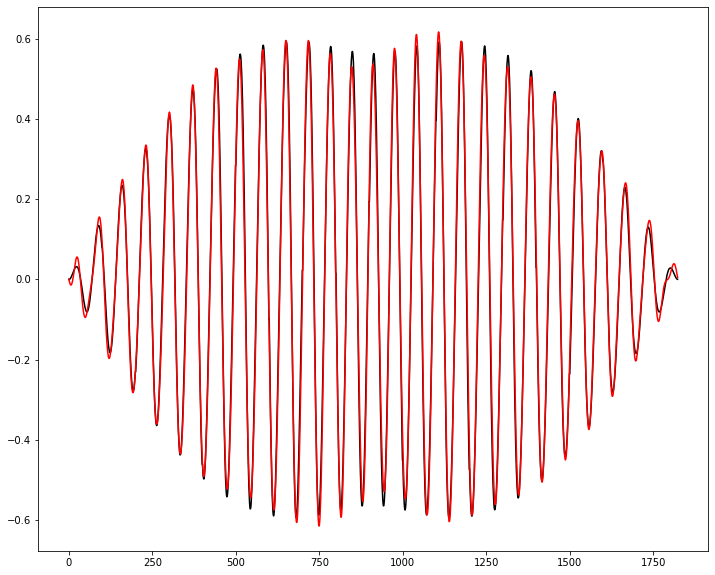

0.11114460068932785


In [171]:
# plot training signal (black) and prediction (red)
plt.figure(figsize=(12,10))
plt.plot(truesig,color='black')
plt.plot(ypred.detach().numpy()[:,0],color='red')
plt.show()

# print naive model's MSE
# by naive model we mean the model where the prediction of y_tru[i,:] is simply x_inp[i,:]
print(np.mean(np.square(truesig)))

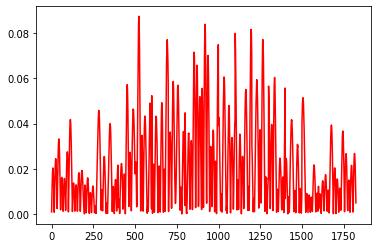

In [172]:
# plot training signal (black) and prediction (red)
plt.plot(np.abs(truesig - ypred.detach().numpy()[:,0]),color='red')
plt.show()


[3.648]
1824
3648
(1824, 1)


0.0008317765476576924

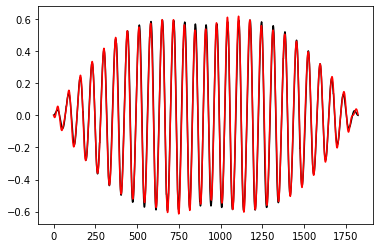

In [173]:
# test model on data from x_inp, y_tru that we did not use for training

# how many periods beyond training data to forecast?
numtestper = 1

# compute test time interval
test_timevar = timevar[bigt:((1+numtestper)*bigt)]
print(test_timevar[0])
print(startind+bigt)
print(startind+(1+numtestper)*bigt)
ypred_test = model(torch.tensor(test_timevar, dtype=torch.float64))
print(ypred_test.detach().numpy().shape)
truetestsig = y_tru[(startind+bigt):(startind+(1+numtestper)*bigt),predelement]

# truetestsig -= x_inp[(startind+bigt):(startind+(1+numtestper)*bigt),1+predelement]


# true and predicted signals
plt.plot(truetestsig,color='black')
plt.plot(ypred_test.detach().numpy()[:,0],color='red')

# test MSE
np.mean(np.square(ypred_test.detach().numpy()[:,0] - truetestsig))


In [174]:
truetestsig[1000]

-0.454488

In [175]:
ypred_test.detach().numpy()[1000,0]

-0.41115569299792176

In [176]:
# naive model MSE
np.mean(np.square(truetestsig))

0.11202944960397976

In [177]:
# test model on data from x_inp_test, y_tru_test

# create timevar corresponding to test set data
next_test_timevar = np.expand_dims(np.arange(x_inp.shape[0],x_inp.shape[0]+x_inp_test.shape[0])*2e-3,1)

# training timevar goes from 0 to 20 (approx)
print(timevar[0])
print(timevar[-1])

# test timevar goes from 20 to 40 (approx)
print(next_test_timevar[0])
print(next_test_timevar[-1])

# start and end indices (need to go to at least 6*bigt for this to make sense)
si = 3+6*bigt - 10000
ei = 3+7*bigt - 10000

# compute prediction and MSE
next_ypred_test = model(torch.tensor(next_test_timevar[si:ei], dtype=torch.float64))
next_truetestsig = y_tru_test[si:ei,predelement]#  - x_inp_test[si:ei,predelement]
np.mean(np.square(next_ypred_test.detach().numpy()[:,0] - next_truetestsig))

[0.]
[19.996]
[19.998]
[39.992]


0.0013573872674484677

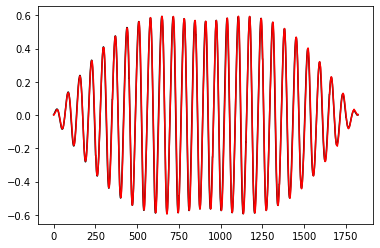

In [164]:
# plot predicted and true signals
plt.plot(next_truetestsig[:],color='black')
plt.plot(next_ypred_test.detach().numpy()[:,0],color='red')

In [165]:
# naive model's MSE
np.mean(np.square(next_truetestsig))

0.11144101533089769